# Hands-on Tutorial on Singular Spectrum Analysis

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dadelforge/MethodsNET2_SSA/blob/main/hands_on_tutorial.ipynb)

This tutorial relies on:
* The [SSALib Python package](https://github.com/ADSCIAN/ssalib) to run Singular Spectrum Analysis routines and explore the results.
* Weekly mortality data provided by the Eurostat [Deaths by week, sex and NUTS 3 region](https://doi.org/10.2908/DEMO_R_MWK3_TS) dataset.

# Install SSALib

SSALib is available on the [Python Package Index (pypi)](https://pypi.org/project/ssalib/). Simply install it using `pip install ssalib` or `!pip install ssalib` in a notebook environment. If any trouble, check the [package repository's instruction](https://github.com/ADSCIAN/ssalib) on GitHub.

**Note**: if already installed, you may comment the first line of the cell below, and simply import the `ssalib` module.

In [1]:
#!pip install ssalib  # uncomment this line if not installed yet
import ssalib
from ssalib import SingularSpectrumAnalysis
print(ssalib.__version__)

0.1.2b1


## Other imports for tutorial

In [2]:
import requests  # Requests is a Python library for making HTTP requests
import io  # IO is a Python library for input/output operations
import numpy as np  # NumPy is a Python library for numerical computing
import pandas as pd  # Pandas is a Python library for data analysis
import matplotlib as mpl  # Matplotlib is a Python library for plotting
import matplotlib.pyplot as plt
for package in [requests, pd, mpl]:
    print(package.__name__, package.__version__)

requests 2.32.5
pandas 2.3.2
matplotlib 3.10.6


# Load or Download Data

We will use weekly mortality data for Province of Walloon Brabant (NUTS Code: BE31) between 2001 and 2024. We excluded the years 2001 and 2025 because they were incomplete.

## Load Locally

If you downloaded the data folder and files on your local machine, you can use the [`pandas`](https://pandas.pydata.org/) Python package to read and parse the csv file.

**Note**: you can also access the data and download it from the Eurostat portal:

In [3]:

df = pd.read_csv('data/demo_r_mwk3_ts__custom_17982848_linear.csv')
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1252 entries, 0 to 1251
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATAFLOW     1252 non-null   object 
 1   LAST UPDATE  1252 non-null   object 
 2   freq         1252 non-null   object 
 3   sex          1252 non-null   object 
 4   unit         1252 non-null   object 
 5   geo          1252 non-null   object 
 6   TIME_PERIOD  1252 non-null   object 
 7   OBS_VALUE    1252 non-null   int64  
 8   OBS_FLAG     104 non-null    object 
 9   CONF_STATUS  0 non-null      float64
dtypes: float64(1), int64(1), object(8)
memory usage: 97.9+ KB
None
                    DATAFLOW        LAST UPDATE    freq    sex    unit  \
0  ESTAT:DEMO_R_MWK3_TS(1.0)  04/09/25 23:00:00  Weekly  Total  Number   
1  ESTAT:DEMO_R_MWK3_TS(1.0)  04/09/25 23:00:00  Weekly  Total  Number   
2  ESTAT:DEMO_R_MWK3_TS(1.0)  04/09/25 23:00:00  Weekly  Total  Number   
3  ESTAT:DEMO_R_MWK3_TS(1

## Download from GitHub

In [4]:

CSV_URL = "https://raw.githubusercontent.com/dadelforge/MethodsNET2_SSA/main/data/demo_r_mwk3_ts__custom_17982848_linear.csv"
try:
    # Fetch the remote CSV file
    response = requests.get(CSV_URL)
    response.raise_for_status()  # Raise an exception for HTTP errors

    # Load the CSV data into a Pandas DataFrame
    # We use the 'response.text' directly since it's a CSV content
    df = pd.read_csv(io.StringIO(response.text))

    # Display DataFrame information and preview
    print(df.info())
    print(df.head())
except requests.exceptions.RequestException as e:
    print(f"Error fetching the file: {e}")
except pd.errors.ParserError as e:
    print(f"Error parsing the CSV file: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1252 entries, 0 to 1251
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATAFLOW     1252 non-null   object 
 1   LAST UPDATE  1252 non-null   object 
 2   freq         1252 non-null   object 
 3   sex          1252 non-null   object 
 4   unit         1252 non-null   object 
 5   geo          1252 non-null   object 
 6   TIME_PERIOD  1252 non-null   object 
 7   OBS_VALUE    1252 non-null   int64  
 8   OBS_FLAG     104 non-null    object 
 9   CONF_STATUS  0 non-null      float64
dtypes: float64(1), int64(1), object(8)
memory usage: 97.9+ KB
None
                    DATAFLOW        LAST UPDATE    freq    sex    unit  \
0  ESTAT:DEMO_R_MWK3_TS(1.0)  04/09/25 23:00:00  Weekly  Total  Number   
1  ESTAT:DEMO_R_MWK3_TS(1.0)  04/09/25 23:00:00  Weekly  Total  Number   
2  ESTAT:DEMO_R_MWK3_TS(1.0)  04/09/25 23:00:00  Weekly  Total  Number   
3  ESTAT:DEMO_R_MWK3_TS(1

## Data Preprocessing

We clean the dataframe to only keep a time series.

In [5]:
from datetime import date

def iso_week_to_monday(iso_week):
    year, week = map(int, iso_week.split('-W'))
    # Monday is the first day of the week (1)
    return date.fromisocalendar(year, week, 1).strftime('%Y-%m-%d')


In [6]:
# drop unecessary columns

columns_to_drop = [
    'DATAFLOW',
    'LAST UPDATE',
    'freq',
    'sex',
    'unit',
    'geo',
    'OBS_FLAG',
    'CONF_STATUS'
]

columns_to_rename = {
    'TIME_PERIOD': 'iso_week',
    'OBS_VALUE': 'mortality'
}

try:
    df.drop(columns=columns_to_drop, inplace=True)
    df.rename(columns=columns_to_rename, inplace=True)
except KeyError:
    print('Columns not found in dataframe')


df['date'] = df['iso_week'].apply(iso_week_to_monday)
df.set_index('date', inplace=True)
df

,iso_week,mortality
date,,
2001-01-01,2001-W01,76
2001-01-08,2001-W02,76
2001-01-15,2001-W03,62
2001-01-22,2001-W04,58
2001-01-29,2001-W05,55
...,...,...
2024-11-25,2024-W48,93
2024-12-02,2024-W49,71
2024-12-09,2024-W50,83


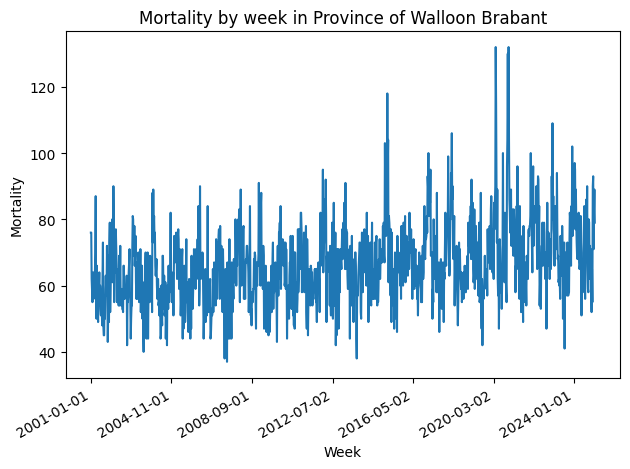

In [7]:
ax = df['mortality'].plot()  # Direct plot using Pandas API
ax.set_xlabel('Week')
ax.set_ylabel('Mortality')
ax.set_title('Mortality by week in Province of Walloon Brabant')
fig = ax.get_figure()  # Retrieve figure object
fig.autofmt_xdate()  # Format x-axis labels
fig.tight_layout()  # Layout adjustment

# SSA Initialization

We now have the `df['mortality']` time series ready for the analysis.

* We instantiate the `SingularSpectrumAnalysis` class with the `df['mortality']` time series object, keeping the other arguments as default (use help for details).
* After the initialization, the matrix to be decomposed has been constructed by default using the Broomhead & King (1986) trajectory matrix approach (hereafter, 'BK'). We can access the trajectory matrix to be decomposed with the `svd_matrix` attribute.
* We can plot the timeseries and its standardized version with the `plot` method, while passing `kind='timeseries'`.
* We can plot the trajectory matrix with the `plot` method, while passing `kind='matrix'`.

**Details**
The 'BK' trajectory matrix $\mathbf{X}$ is mathematically constructed based on a time series $X_t = \{x_1, x_2, \dots, x_N\}$
and the `window` parameter $L$ such that it has a dimension $L \times K$.
$$
\mathbf{X} = \begin{bmatrix}
    x_1 & x_2 & x_3 & \dots & x_K \\
    x_2 & x_3 & x_4 & \dots & x_{K+1} \\
    x_3 & x_4 & x_5 & \dots & x_{K+2} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    x_L &  x_{L+1} & x_{L+2} & \dots & x_{N}
    \end{bmatrix}
$$

* The default `window` parameter, or $L$, is equal to the half-length of the time series (i.e., `len(sst)//2`).
* $\mathbf{X}$ has all its anti-diagonal elements equal, a property that can be used to reconstruct the original timeseries from the matrix.


# SingularSpectrumAnalysis
timeseries: Series, n=1252, mean=1.81, std=0.08
svd_matrix_kind: bk_trajectory (626, 627)
window: 626
standardize: True
svd_solver: numpy_standard
status: Initialized
n_components: None
groups: None


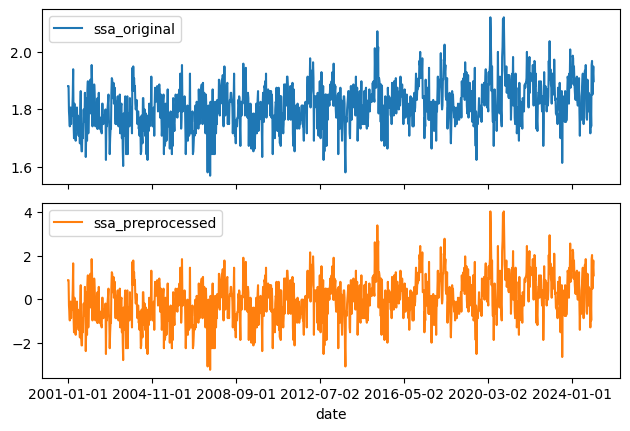

In [8]:
# help(SingularSpectrumAnalysis) # <- Uncomment to get help
ts = np.log10(df['mortality'])
ssa = SingularSpectrumAnalysis(ts)
fig, axes = ssa.plot(kind='timeseries', subplots=True)
print(ssa)

* The values within the matrix range mainly between -2 and 2, except for some outliers corresponding to COVID-19 outbreaks in 2020 and 2021.
* By default, the matrix is constructed using the z-standardized timeseries resulting from the preprocessing.

(626, 627)


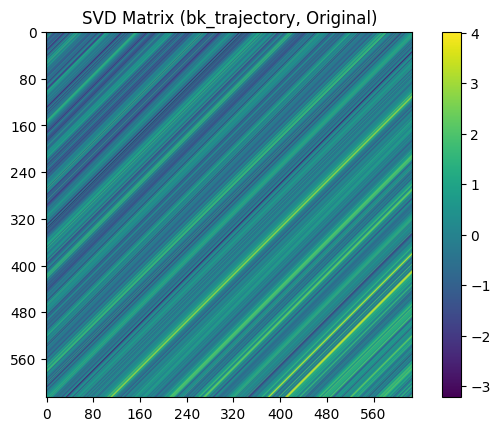

In [9]:
print(ssa.svd_matrix.shape)
fig, ax = ssa.plot(kind='matrix')

## SSA Decomposition

* We can now decompose the matrix by calling the `decompose` method.
* After, we can access the eigentriples (u, s, vt) with the `decomposition_results` attribute.

**Details** The Singular Value Decomposition (SVD) of a matrix $\mathbf{X}$ of shape $L \times K$ can be represented as:

$$
\mathbf{X} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^T
$$

where:

- $\mathbf{U} \in \mathbb{R}^{L \times L}$ is an orthogonal matrix whose columns are called the **left singular vectors** of $\mathbf{X}$.
- $\mathbf{\Sigma} \in \mathbb{R}^{L \times K}$ is a diagonal matrix containing the **singular values** of $\mathbf{X}$ along its diagonal.
- $\mathbf{V} \in \mathbb{R}^{K \times K}$ is an orthogonal matrix whose columns are called the **right singular vectors** of $\mathbf{X}$.
- $\mathbf{V}^T$ is the transpose of $\mathbf{V}$.

Alternatively, SVD can be described in the sum form as:

$$
\mathbf{X} = \sum_{i=1}^{r} \sigma_i \mathbf{u}_i \mathbf{v}_i^T
$$

where:

- $r$ is the **rank** of the matrix $\mathbf{X}$.
- $\sigma_i$ are the **singular values**, with $\sigma_1 \geq \sigma_2 \geq \dots \geq \sigma_r > 0$.
- $\mathbf{u}_i \in \mathbb{R}^L$ and $\mathbf{v}_i \in \mathbb{R}^K$ are the **left** and **right singular vectors** corresponding to $\sigma_i$.

In this representation, SVD expresses the matrix $\mathbf{X}$ as a weighted sum of rank-1 matrices formed by the outer product of the left and right singular vectors.

We refer to $\mathbf{u}_i$, $\sigma_i$, $\mathbf{v}_i^T$ as the ith eigentriple. $\mathbf{X}_i = \sigma_i \mathbf{u}_i \mathbf{v}_i^T$ is also referred to as an elementary matrix.

In [10]:
ssa.decompose()
print(ssa)
u, s, vt = ssa.decomposition_results
print('Eigentriple dimension:', [i.shape for i in ssa.decomposition_results])


# SingularSpectrumAnalysis
timeseries: Series, n=1252, mean=1.81, std=0.08
svd_matrix_kind: bk_trajectory (626, 627)
window: 626
standardize: True
svd_solver: numpy_standard
status: Decomposed
n_components: 626
groups: None
Eigentriple dimension: [(626, 626), (626,), (627, 627)]


## SSA Components Selection

* The next step involves selecting meaningful groups of components for the reconstruction step.
* We visualize the singular values with the `plot` method, limited to the first 50 components.
* Singular values are by default presented in decreasing order of captured variance, meaning the first components capture the most part of the signal dynamics.

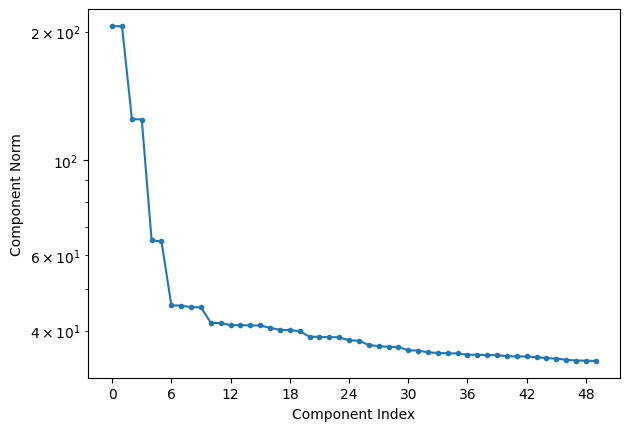

In [11]:
fig, ax = ssa.plot(n_components=50, marker='.')  # kind='values' by default

We can observe
- a two-by-two component staircase pattern for the first 6 components;
- then, longer plateau patterns, especially for the first 6th to 10th components;
- then, a noise floor with decreasing values without any clear pattern;

**Note**: In Python, the first element of an array has index 0. Hence, index 0 corresponds to the first singular value.

In general, the first six components are well separated from the rest of the signal, that is less structured. Very often, two close singular values are associated with the quadrature components of clean cyclic patterns (i.e., sine and cosine) We can also plot the values, ordered by the frequency of the associated components, by passing the argument `rank_by='freq'` to the `plot` method. We will also highlight the annual frequency (1/12) and semi-annual (2/12) to increase legibility.

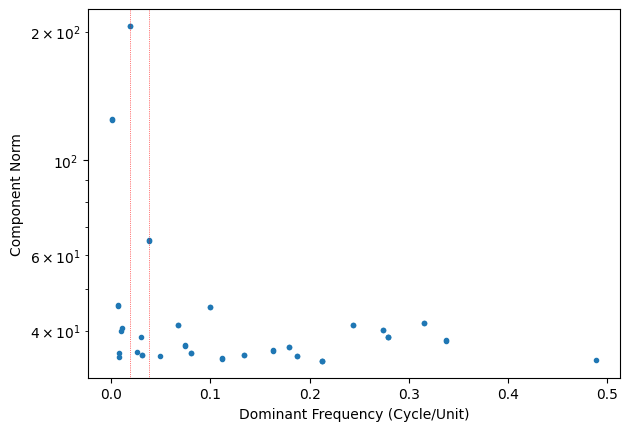

In [12]:
fig, ax = ssa.plot(rank_by='freq', n_components=50, marker='.', ls='none')
_ = ax.axvline(1 / 52.14, color='r', ls=':', lw=.5)  # annual cycle
_ = ax.axvline(2 / 52.14, color='r', ls=':', lw=.5)  # semi-annual cycle frequency

In this case, we observe:
* The main components, [0,1] are perfectly overlapping on the frequency of the annual cycle;
* The components [2,3] in the previous figure, have a very low frequency, i.e., they correspond to the trend of the signal;
* The components [4,5] are perfectly overlapping on the semi-annual frequency.

Hence, we have likely identify the main trend and cyclic behavior in our signal.

## SSA Reconstruction

* For the reconstruction, a matrix can be reconstructed for any selection of components, based on the SVD additive formula.

Given a group of indices $I = {0,1}$ for instance, we can reconstruct a matrix capturing the seasonal behavior with:
$$
\mathbf{X}_I = \sum_{i \in I} \sigma_i \mathbf{u}_i \mathbf{v}_i^T
$$

* You can check it with the `plot` methods and the `kind` argument set to matrix, which also enable to visualize reconstructed matrix based on selected indices.


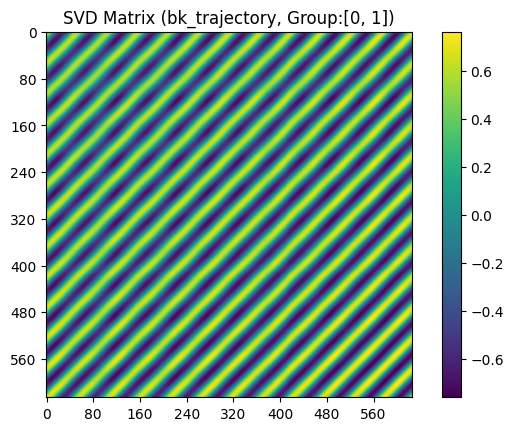

In [13]:
fig, ax = ssa.plot(kind='matrix', indices=[0, 1])

We indeed observe a perfectly regular pattern corresponding to the annual cycle associated with the components [2,3].

However, the matrix should still be transformed back into a timeseries component, which can be done by averaging the anti-diagonals of the reconstructed trajectory matrix.

The `ssalib` API let you recompose signals in a very flexible way using the getitem api with integers, list of integers, or slicing referring to the component indices. Hence, we can recover the signal associated with our 6 main components:

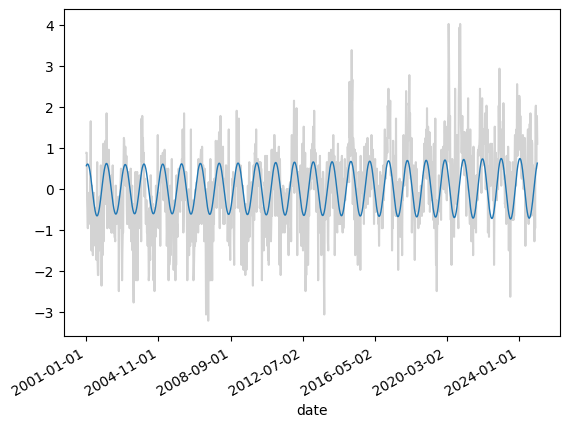

In [14]:
ax = ssa['ssa_preprocessed'].plot(color='lightgrey')
ax.plot(ssa[[0,1]], lw=1.)  # reconstructed annual cycle
ax.get_figure().autofmt_xdate()

Alternatively, we could use a more formal approach using the `reconstruct` method while passing a dictionary with the desired groups.

In the following example, we reconstruct the same groups as before.

In [15]:
groups = {
    'Trend': [2, 3],
    '1Y_cycle': [0, 1],
    '6M_cycle': [4, 5],
    'Denoised_signal': [0, 1, 2, 3, 4, 5]
}
ssa.reconstruct(groups)

Reconstructed groups contain duplicate indices: [0, 1, 2, 3, 4, 5]


SingularSpectrumAnalysis(timeseries=<Series shape=(1252,)>, window=626, svd_matrix='SSAMatrixType.BK_TRAJECTORY', svd_solver='numpy_standard', standardize=True)

We got a warning because we reconstructed different groups using multiple time the same indices, which means that we should not sum the signal we have reconstructed. We can now also retrieve a component by its name:

date
2001-01-01   -0.476646
2001-01-08   -0.478541
2001-01-15   -0.479540
2001-01-22   -0.478034
2001-01-29   -0.474534
Name: Trend, dtype: float64


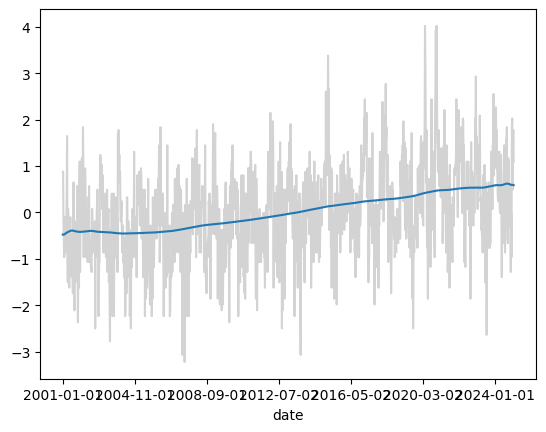

In [16]:
ax = ssa['ssa_preprocessed'].plot(color='lightgrey')
_ = ssa['Trend'].plot(ax=ax)  # plot trend
print(ssa['Trend'].head(5))  # print first 5 trend values

You can also easily plot the components using the `plot` method with `kind='timeseries`, and select which one to include using the `include` argument. This approach also has the advantage of rescaling the components to its original standard deviation and mean if `rescale=True`.

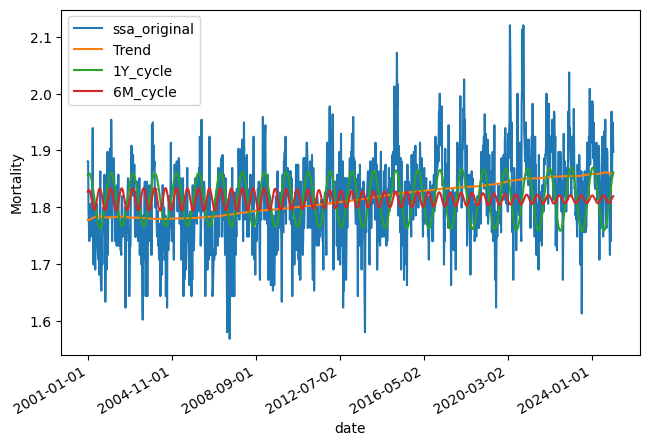

In [17]:
fig, ax = ssa.plot('timeseries',
                   include=['ssa_original', 'Trend', '1Y_cycle', '6M_cycle'],
                   rescale=True)
_ = ax.set_ylabel('Mortality')
fig.autofmt_xdate()

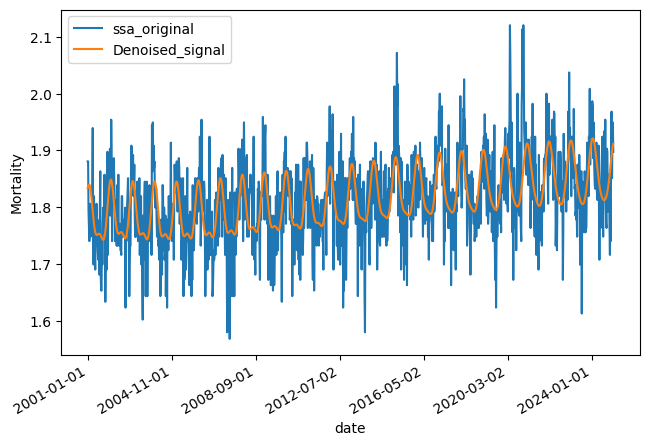

In [18]:
fig, ax = ssa.plot('timeseries',
                   include=['ssa_original', 'Denoised_signal'],
                   rescale=True)
_ = ax.set_ylabel('Mortality')
fig.autofmt_xdate()

It is also possible to reconstruct components using the singular values indices and slices.

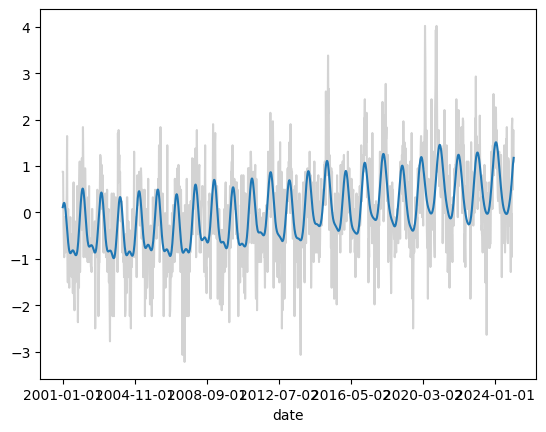

In [19]:
ax = ssa['ssa_preprocessed'].plot(color='lightgrey')
_ = ssa[:8].plot(ax=ax)

If the time series has to be rescaled, it is possible to access the mean and the standard deviation parameters from the ssa object.

In [20]:
ssa.mean_, ssa.std_

(np.float64(1.8139417422152373), np.float64(0.07633231331573456))

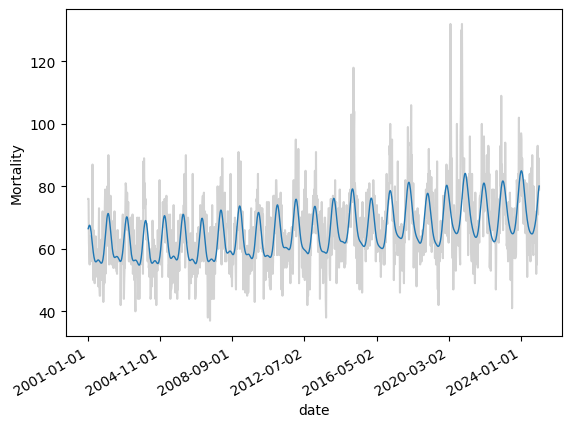

In [21]:
ax = np.power(10, ssa['ssa_original']).plot(color='lightgrey')
ax.plot(np.power(10, (ssa[:8] * ssa.std_) + ssa.mean_), lw=1.)
ax.set_ylabel('Mortality')
ax.get_figure().autofmt_xdate()


Finally, SSALib makes it possible to export all reconstructed components using the `to_frame` method. The arguments can be used to include or exclude components, and specify whether rescaling is required.

In [22]:
#help(ssa.to_frame) # <- uncomment to get help
ssa.to_frame()

,ssa_original,ssa_preprocessed,ssa_reconstructed,ssa_residuals,Trend,1Y_cycle,6M_cycle,Denoised_signal
date,,,,,,,,
2001-01-01,1.880814,0.876062,0.876062,0.617288,-0.476646,0.560371,0.175049,0.258774
2001-01-08,1.880814,0.876062,0.876062,0.571494,-0.478541,0.581336,0.201773,0.304568
2001-01-15,1.792392,-0.282319,-0.282319,-0.612227,-0.479540,0.594007,0.215441,0.329908
2001-01-22,1.763428,-0.661761,-0.661761,-1.003546,-0.478034,0.600409,0.219410,0.341785
2001-01-29,1.740363,-0.963931,-0.963931,-1.301340,-0.474534,0.599463,0.212481,0.337409
...,...,...,...,...,...,...,...,...
2024-11-25,1.968483,2.024584,2.024584,1.007867,0.595190,0.412476,0.009051,1.016717
2024-12-02,1.851258,0.488870,0.488870,-0.610360,0.592977,0.477139,0.029115,1.099231
2024-12-09,1.919078,1.377351,1.377351,0.202328,0.592614,0.535246,0.047162,1.175022
